# Libraries

In [1]:
import joblib

import math

import matplotlib.pyplot as plt

import numpy as np

import os

from scipy.signal import savgol_filter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Constant

In [2]:
INPUT_DIR = os.path.join('..', 'data', 'processed')
MODEL_DIR = os.path.join('..', 'models')
SCALER_DIR = os.path.join('..', 'data', 'scalers')
MODEL_VERSION = 'v01'
SMOOTHING_WINDOW = 30

# Config

In [3]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Import

In [4]:
class CombatForecastDataset(Dataset):
    def __init__(self, path_lb_our, path_lb_bandit, path_fc_action, path_fc_our, path_fc_bandit):
        self.lb_our = np.load(path_lb_our)
        self.lb_bandit = np.load(path_lb_bandit)
        self.fc_action = np.load(path_fc_action)
        self.fc_our = np.load(path_fc_our)
        self.fc_bandit = np.load(path_fc_bandit)
        self.nr_of_padding = self.lb_our.shape[-1] - self.lb_bandit.shape[-1]

    def __len__(self):
        return len(self.lb_our)

    def __getitem__(self, idx):
        lb_our = self.lb_our[idx]
        lb_bandit = self.lb_bandit[idx]
    
        pad_width = ((0, 0), (0, self.nr_of_padding))
        lb_bandit_padded = np.pad(lb_bandit, pad_width=pad_width, mode='constant', constant_values=0)
        src = np.concatenate([lb_our, lb_bandit_padded], axis=0)
        
        # Decoder input
        # tgt_input = self.fc_action[idx]
        dec_beg = self.lb_bandit[idx][[-1], [3, 7, 11]]
        tgt_input = self.fc_bandit[idx]
        tgt_input = np.vstack([dec_beg, tgt_input[:-1]])

        # Target output
        tgt_output = self.fc_bandit[idx]
    
        return (
            torch.tensor(src, dtype=torch.float32),
            torch.tensor(tgt_input, dtype=torch.float32),
            torch.tensor(tgt_output, dtype=torch.float32)
        )

In [5]:
testing_dataset = CombatForecastDataset(
    os.path.join(INPUT_DIR, 'test_lb_state_our.npy'),
    os.path.join(INPUT_DIR, 'test_lb_state_bandit.npy'),
    os.path.join(INPUT_DIR, 'test_fc_action_our.npy'),
    os.path.join(INPUT_DIR, 'test_fc_state_our.npy'),
    os.path.join(INPUT_DIR, 'test_fc_state_bandit.npy'))

In [6]:
scaler_cord_x = joblib.load(os.path.join(SCALER_DIR, 'cord_x.pkl'))
scaler_cord_y = joblib.load(os.path.join(SCALER_DIR, 'cord_y.pkl'))
scaler_cord_z = joblib.load(os.path.join(SCALER_DIR, 'cord_z.pkl'))

# Analysis

## UDF 

In [7]:
class ForecastTransformer(nn.Module):
    def __init__(self, enc_input_dim=18, dec_input_dim=10, out_dim=31,
                 d_model=256, nhead=4, num_encoder_layers=3, num_decoder_layers=3,
                 dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # Project encoder and decoder inputs to d_model
        self.encoder_input_proj = nn.Linear(enc_input_dim, d_model)
        self.decoder_input_proj = nn.Linear(dec_input_dim, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )

        # Output projection to target dimension
        self.output_proj = nn.Linear(d_model, out_dim)

    def forward(self, src, tgt_input, tgt_mask=None):
        # src: (batch, src_seq_len, enc_input_dim)
        # tgt_input: (batch, tgt_seq_len, dec_input_dim)

        src = self.encoder_input_proj(src) * math.sqrt(self.d_model)  # (batch, 20, d_model)
        tgt = self.decoder_input_proj(tgt_input) * math.sqrt(self.d_model)  # (batch, 3, d_model)

        src = self.positional_encoding(src).transpose(0, 1)  # (20, batch, d_model)
        tgt = self.positional_encoding(tgt).transpose(0, 1)  # (3, batch, d_model)

        out = self.transformer(src, tgt, tgt_mask=tgt_mask)  # (3, batch, d_model)
        out = self.output_proj(out.transpose(0, 1))  # (batch, 3, out_dim)

        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)  # correctly handled across devices

    def forward(self, x):
        # Automatically move self.pe to same device as x
        return x + self.pe[:, :x.size(1)].to(x.device)

## Compile

In [8]:
test_data_loader = DataLoader(testing_dataset, batch_size=128, shuffle=True)
model = ForecastTransformer(
    enc_input_dim=15,
    dec_input_dim=3,
    out_dim=3,
    d_model=256,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=512,
    dropout=0.1)\
    .to(device)

model.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'{MODEL_VERSION}.pth')))

model.eval()

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ForecastTransformer(
  (encoder_input_proj): Linear(in_features=15, out_features=256, bias=True)
  (decoder_input_proj): Linear(in_features=3, out_features=256, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNo

## Predict

In [9]:
def generate_square_subsequent_mask(sz):
    return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

all_predictions = []
all_truth = []

model.eval()
with torch.no_grad():
    for src, tgt_input, tgt_output in test_data_loader:
        src, tgt_input, tgt_output = src.to(device), tgt_input.to(device), tgt_output.to(device)

        nr_of_timesteps = tgt_input.shape[1]

        generated = tgt_input[:, [0]]  # (B, 1)
        output_tokens = []

        for t in range(1, nr_of_timesteps + 1):
            tgt_mask = generate_square_subsequent_mask(generated.shape[1]).to(device)

            out = model(src, generated, tgt_mask=tgt_mask)  # (B, T, D)
            next_token = out[:, -1:].detach()  # (B, 1)
            output_tokens.append(next_token)

            generated = torch.cat([generated, next_token], dim=1)  # (B, T+1)

        outputs = torch.cat(output_tokens, dim=1)  # shape (B, T)

        all_predictions.append(outputs.cpu())
        all_truth.append(tgt_output.cpu())

all_predictions = torch.cat(all_predictions, dim=0)
all_truth = torch.cat(all_truth, dim=0)

## Analyze

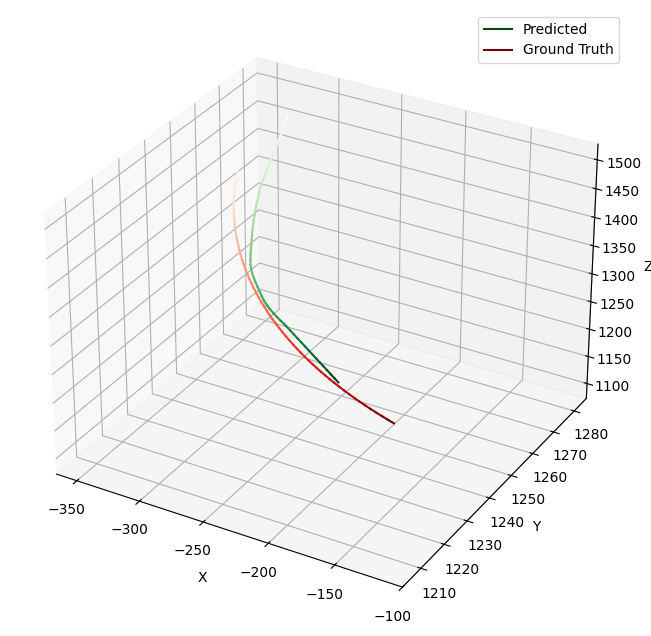

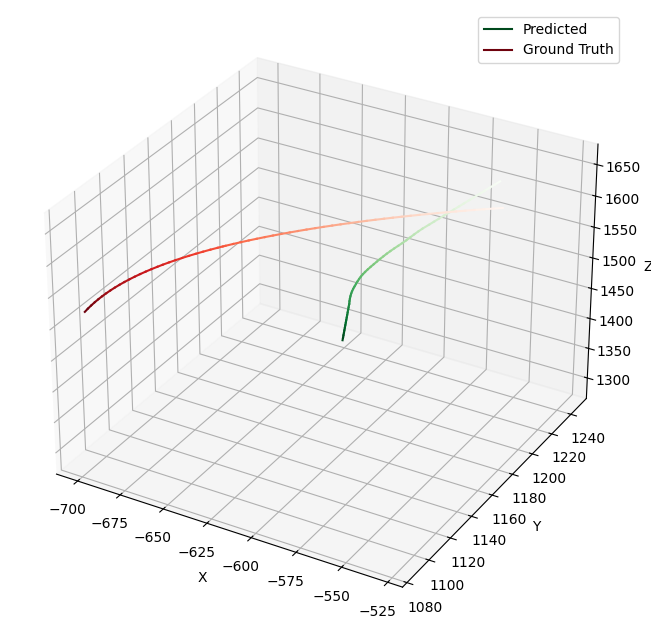

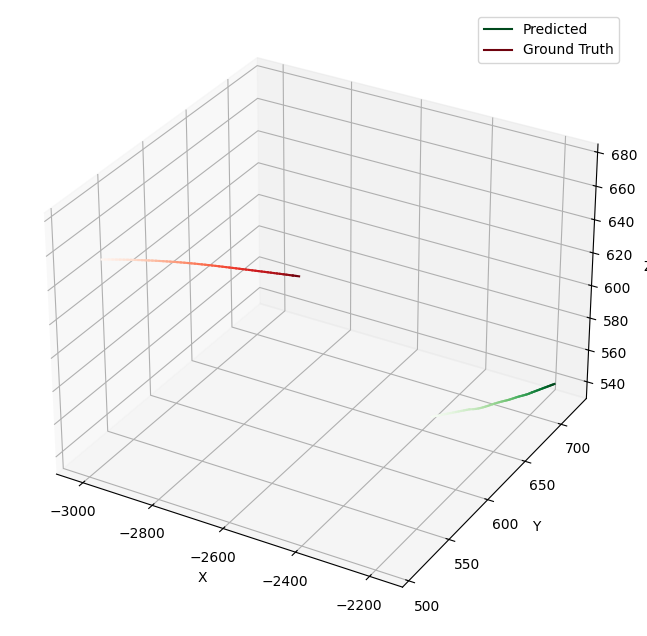

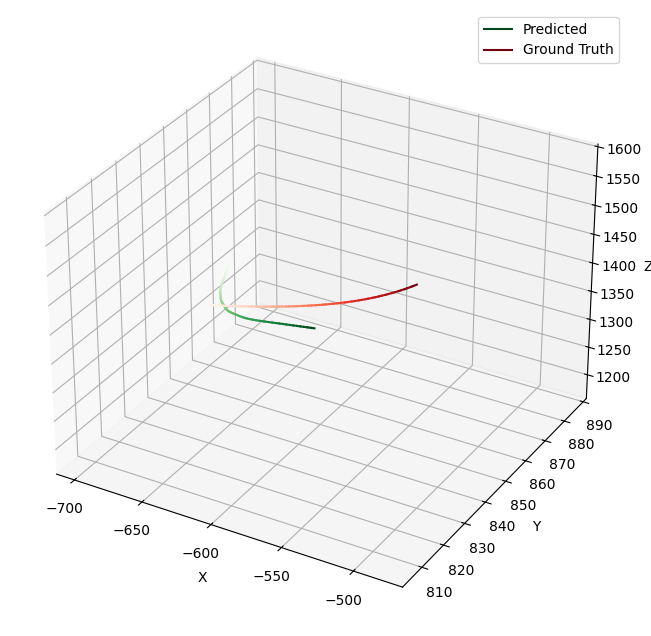

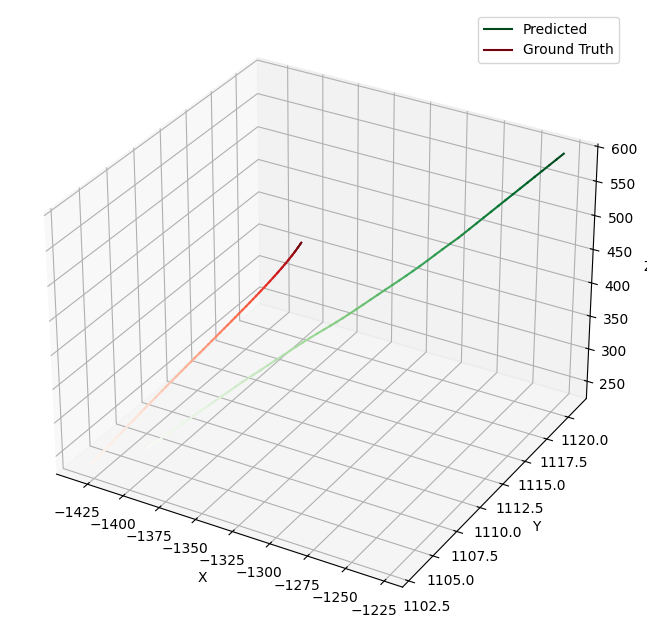

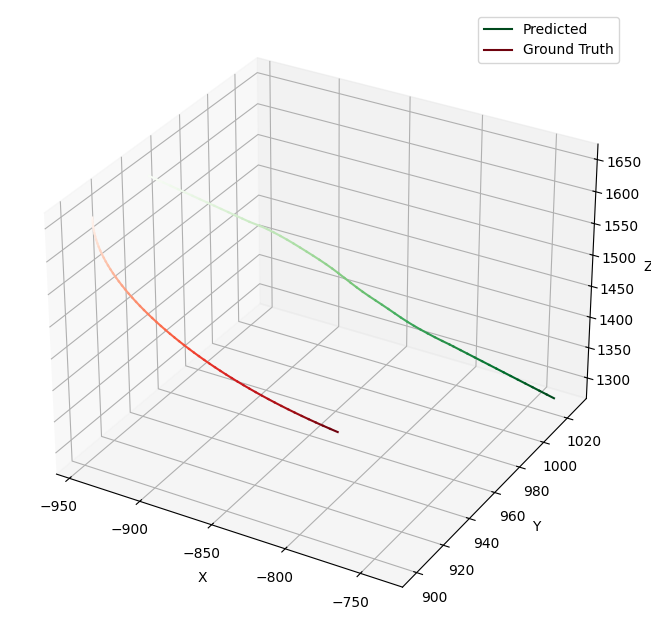

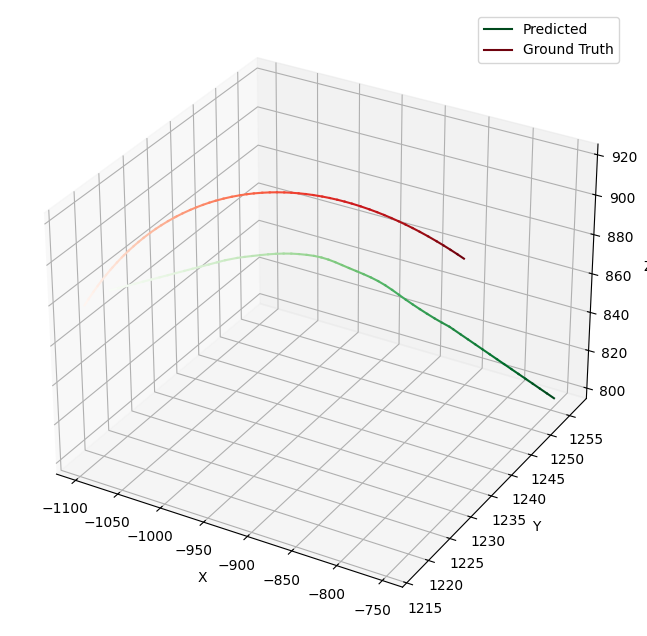

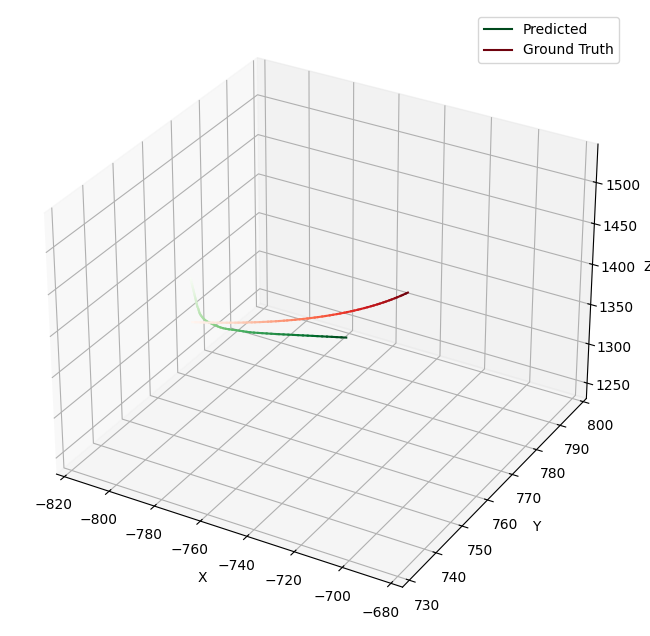

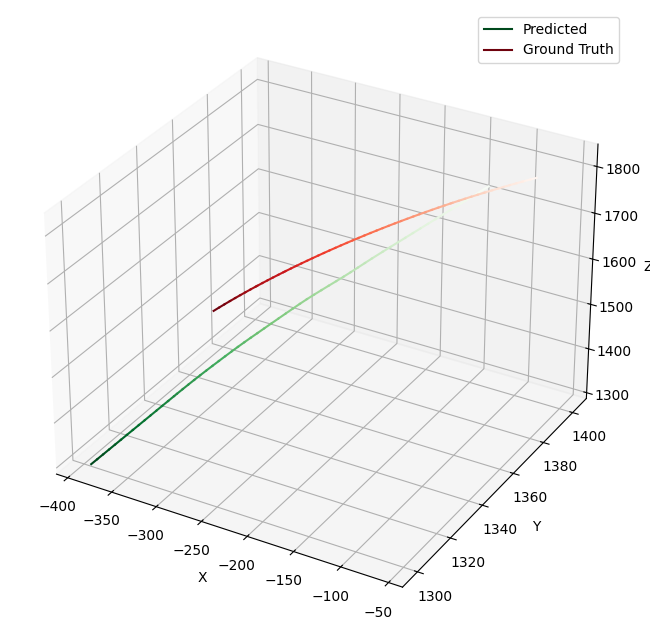

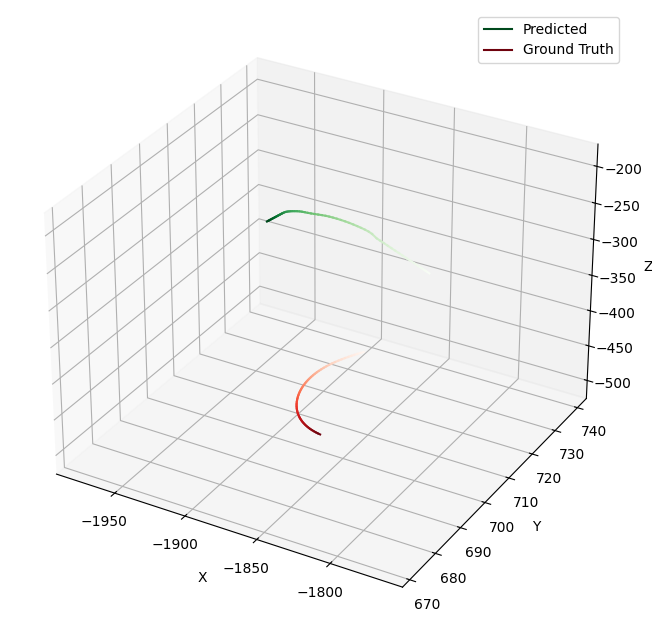

In [10]:
import random

samples = random.sample(range(0, len(all_predictions)), 10)

for sample_id in samples:
    pred = all_predictions[sample_id]
    truth = all_truth[sample_id]
    
    # Extracting x, y, and z coordinates for both predicted and ground truth
    x_pred = scaler_cord_x.inverse_transform(pred[:, [0]]).squeeze()
    y_pred = scaler_cord_y.inverse_transform(pred[:, [1]]).squeeze()
    z_pred = scaler_cord_z.inverse_transform(pred[:, [2]]).squeeze()
    
    x_gt = scaler_cord_x.inverse_transform(truth[:, [0]]).squeeze()
    y_gt = scaler_cord_y.inverse_transform(truth[:, [1]]).squeeze()
    z_gt = scaler_cord_z.inverse_transform(truth[:, [2]]).squeeze()
    
    x_pred = savgol_filter(x_pred, window_length=SMOOTHING_WINDOW, polyorder=1)
    y_pred = savgol_filter(y_pred, window_length=SMOOTHING_WINDOW, polyorder=1)
    z_pred = savgol_filter(z_pred, window_length=SMOOTHING_WINDOW, polyorder=1)
    
    # x_pred = pred[:, [0]].squeeze()
    # y_pred = pred[:, [1]].squeeze()
    # z_pred = pred[:, [2]].squeeze()
    
    # x_gt = truth[:, [0]].squeeze()
    # y_gt = truth[:, [1]].squeeze()
    # z_gt = truth[:, [2]].squeeze()
    
    # Create a figure and a 3D axis
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a colormap, normalize the timesteps to the range [0, 1]
    cmap = plt.get_cmap('Greens')
    norm = plt.Normalize(vmin=0, vmax=len(x_pred) - 1)
    
    # Plotting the predicted trajectory with color based on the timestep
    for i in range(len(x_pred) - 1):
        ax.plot([x_pred[i], x_pred[i+1]], [y_pred[i], y_pred[i+1]], [z_pred[i], z_pred[i+1]], color=cmap(norm(i)),  label='Predicted' if i == (len(x_gt) - 2) else "")

    cmap = plt.get_cmap('Reds')
    norm = plt.Normalize(vmin=0, vmax=len(x_pred) - 1)
    # Plotting the ground truth trajectory with dashed lines and same colors as predicted
    for i in range(len(x_gt) - 1):
        ax.plot([x_gt[i], x_gt[i+1]], [y_gt[i], y_gt[i+1]], [z_gt[i], z_gt[i+1]], color=cmap(norm(i)), label='Ground Truth' if i == (len(x_gt) - 2) else "")
    
    # Labeling axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.show()